# Comparing the difference using `mean` and `pct_50` for speeds

In [7]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime

%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [8]:
CONFIG = configparser.ConfigParser()
CONFIG.read(r'/home/jchew/local/db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [12]:
# Compare difference between mean and median speed in each segment (randomly pick 20 segments)
sql = pg.SQL('''
SELECT a.segment_id, a.datetime_bin::time AS time, 
AVG(a.segment_tt_avg_hc) AS segment_tt_avg, AVG(a.segment_tt_med_hc) AS segment_tt_med, AVG(a.data_pct_hc) AS data_pct, b.length,
b.length/avg(a.segment_tt_avg_hc) * 3.6 AS spd_avg, b.length/avg(a.segment_tt_med_hc) * 3.6 AS spd_med
FROM congestion.tt_segments_30min_v1_avg a
JOIN congestion.segments_v1 b USING (segment_id)
WHERE segment_id IN (111, 163, 200, 308, 595, 888, 1500, 2020, 2828, 3432, 4751, 5555, 6000, 6868, 7235, 8985, 9993, 10033, 10521, 11550)
GROUP BY segment_id, datetime_bin::time, b.length
''')
speeds = pandasql.read_sql(sql, con)

Text(0.5, 0.98, 'Mean vs Median Speeds')

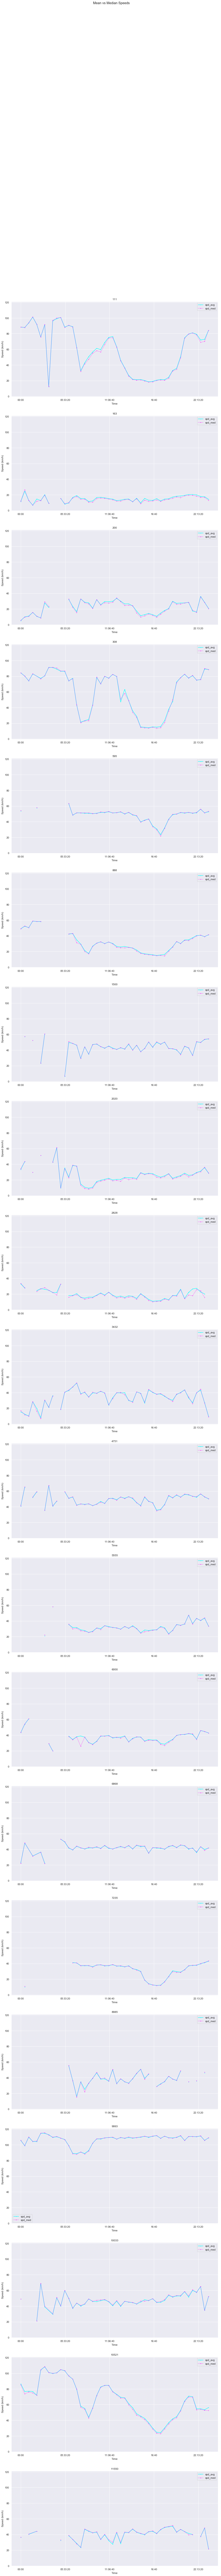

In [15]:
# Every single subplot shares the same x-axis and y-axis
## P.S: have trouble fixing the x-axis to make them more uniform and tidy
segments = speeds.groupby('segment_id')
fig, ax = plt.subplots (20,1, figsize=(16,180), sharex=True, sharey=True)
for i, (segment_id, data) in enumerate(segments):
   
    ax[i].plot(data.time, data.spd_avg, label = 'spd_avg', marker = '+', markersize = 3, linestyle = '-', color = 'aqua')
    ax[i].plot(data.time, data.spd_med, label = 'spd_med', marker = '.', markersize = 3, linestyle = ':', color = 'magenta')
    
    ax[i].legend()
    ax[i].set_xlabel('Time', labelpad=6)
    ax[i].set_ylabel('Speed (km/h)')
    ax[i].set_title(segment_id)  
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].yaxis.set_tick_params(which='both', labelleft=True)
    # ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
    # ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
    
fig.suptitle('Mean vs Median Speeds')

## Investigate why speeds in some segments fluctuate so much (so jumpy) and do not have a clear trough for peak period

In [10]:
# Query to figure out the number of rows of data we have for each type of speeds and calculate the ratio
sql = pg.SQL('''
SELECT segment_id, COUNT(datetime_bin)::float AS count_bins, 
COUNT(segment_tt_avg_all)::float AS count_all, 
COUNT(segment_tt_avg_hc)::float AS count_hc,
 (COUNT(segment_tt_avg_all))::float / (COUNT(datetime_bin))::float AS all_ratio,
 (COUNT(segment_tt_avg_hc))::float / (COUNT(datetime_bin))::float AS hc_ratio,
(COUNT(segment_tt_avg_hc))::float / (COUNT(segment_tt_avg_all))::float AS hc_all_ratio
FROM congestion.tt_segments_30min_v1_avg
WHERE segment_id IN (111, 163, 200, 308, 595, 888, 1500, 2020, 2828, 3432, 4751, 5555, 6000, 6868, 7235, 8985, 9993, 10033, 10521, 11550)
GROUP BY segment_id
''')
speeds = pandasql.read_sql(sql, con)
print_table(sql, con)

segment_id,count_bins,count_all,count_hc,all_ratio,hc_ratio,hc_all_ratio
111,2857.0,2712.0,2132.0,0.949247,0.746237,0.786136
163,2199.0,1890.0,772.0,0.859482,0.351069,0.408466
200,1883.0,1613.0,514.0,0.856612,0.272969,0.318661
308,1634.0,1634.0,1365.0,1.000000,0.835373,0.835373
595,2325.0,2120.0,1217.0,0.911828,0.523441,0.574057
888,2398.0,2311.0,1627.0,0.963720,0.678482,0.704024
1500,1536.0,1431.0,535.0,0.931641,0.348307,0.373864
2020,2229.0,2153.0,1819.0,0.965904,0.816061,0.844868
2828,1851.0,1724.0,849.0,0.931388,0.458671,0.492459
3432,1581.0,1477.0,651.0,0.934219,0.411765,0.440758


**The reason is that there isn't much data with high confidence for that segment.** The ratio of count_hc_speeds to count_timebins can be as low as 0.105 such as the one on segment 8985. Clear and smooth troughs during peak periods can be seen for those segments with `hc_ratio` of greater than 0.7 generally.

## Investigate why the mean and median speeds in each segment deviate so much 

In [16]:
# Spotted a few link_dir from the segments above with a big difference between mean and median speeds and looked into the data in its raw form
sql = pg.SQL('''
SELECT * FROM congestion.data_fall2019_5min
WHERE link_dir = '756087427T'
AND tx BETWEEN '2019-09-11 20:00:00' AND '2019-09-11 20:30:00'
AND confidence >= 30

UNION

SELECT * FROM congestion.data_fall2019_5min
WHERE link_dir = '1052658517F'
AND tx BETWEEN '2019-09-03 13:30:00' AND '2019-09-03 14:00:00'
AND confidence >= 30
''')
speeds = pandasql.read_sql(sql, con)
print_table(sql, con)

link_dir,tx,epoch_min,length,mean,stddev,min_spd,max_spd,confidence,pct_5,pct_10,pct_15,pct_20,pct_25,pct_30,pct_35,pct_40,pct_45,pct_50,pct_55,pct_60,pct_65,pct_70,pct_75,pct_80,pct_85,pct_90,pct_95
1052658517F,2019-09-03 13:50:00,166,91,14.7,12.4,7,29,30,7,7,7,7,7,7,7,8,8,8,12,16,21,25,29,29,29,29,29
756087427T,2019-09-11 20:10:00,242,133,17.3,13.1,7,32,30,7,7,7,7,7,8,9,11,12,13,17,21,24,28,32,32,32,32,32
756087427T,2019-09-11 20:20:00,244,133,11.7,10.3,4,28,40,4,4,4,4,4,4,4,4,4,4,8,13,17,20,23,25,27,28,28


If you look at column `mean` and `pct_50` above, the speeds are indeed very different. **The reason is that the speeds varies greatly and escalates considerably beyond `pct_55` or `pct_60`.** 